<a href="https://colab.research.google.com/github/vimesh630/Spice_Price_Predction_VERGER/blob/Cinnamon/Preprocessing_for_Cinnamon_Price_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from datetime import datetime

#3. Set Paths

In [15]:
dataset_path = '/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_New_0001.xlsx'
save_path = '/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction'
os.makedirs(save_path, exist_ok=True)

#4. Load Dataset

In [16]:
df = pd.read_excel(dataset_path)
print("Initial shape:", df.shape)
df.head()

Initial shape: (2772, 16)


,Month,Grade,Region,Is_Active_Region,Regional_Price,National_Price,Seasonal_Impact,Local_Production_Volume,Local_Export_Volume,Global_Production_Volume,Global_Consumption_Volume,Temperature,Rainfall,Exchange_Rate,Inflation_Rate,Fuel_Price
0,2020-01-01,alba,ratnapura,1,2733.25,2758.1875,0,0.0,1310.5,19156.0,11106.0,25.560625,57.7385,181.4036,5.7,104
1,2020-01-03,alba,colombo,0,NaN,2758.1875,0,0.0,1310.5,19156.0,11106.0,25.560625,57.7385,181.4036,5.7,104
2,2020-01-04,alba,kalutara,1,2566.50,2758.1875,0,0.0,1310.5,19156.0,11106.0,25.560625,57.7385,181.4036,5.7,104
3,2020-01-05,alba,galle,1,2745.00,2758.1875,0,0.0,1310.5,19156.0,11106.0,25.560625,57.7385,181.4036,5.7,104
4,2020-01-06,alba,matara,1,3006.50,2758.1875,0,0.0,1310.5,19156.0,11106.0,25.560625,57.7385,181.4036,5.7,104


#5. Parse Dates

In [17]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.sort_values(by='Month')

#6. Handle Missing Values Using KNN Imputation

In [19]:
features_to_impute = df.columns.drop(['Month', 'Grade', 'Region'])
imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df[features_to_impute]), columns=features_to_impute)
df_imputed['Month'] = df.index.values

#7. Normalize the features

In [22]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_imputed.drop('Month', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=features_to_impute)
scaled_df['Month'] = df_imputed['Month'].values

#8. Sequence Preparation

In [23]:
def create_seq2seq_data(df, sequence_length=12, prediction_length=3):
    X, y = [], []
    df = df.sort_values("Month").reset_index(drop=True)
    data = df.drop("Month", axis=1).values

    for i in range(len(data) - sequence_length - prediction_length + 1):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+prediction_length])

    return np.array(X), np.array(y)

#9. Split the Dataset

In [26]:
split_date = pd.to_datetime("2024-07-01")
scaled_df['Month'] = pd.to_datetime(scaled_df['Month'])
train_df = scaled_df[scaled_df["Month"] < split_date].reset_index(drop=True)
test_df = scaled_df[scaled_df["Month"] >= split_date].reset_index(drop=True)

#10. Create Sequences

In [27]:
X_train, y_train = create_seq2seq_data(train_df)
X_test, y_test = create_seq2seq_data(test_df)

print("Train sequences:", X_train.shape, y_train.shape)
print("Test sequences:", X_test.shape, y_test.shape)

Train sequences: (2758, 12, 13) (2758, 3, 13)
Test sequences: (0,) (0,)


#11. Save Preprocessed Data

In [28]:
np.savez_compressed(os.path.join(save_path, "seq2seq_cinnamon_data.npz"),
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test)

print(f"\n✅ Preprocessed data saved to: {save_path}")


✅ Preprocessed data saved to: /content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction


#12. Plotting an Example Sequence

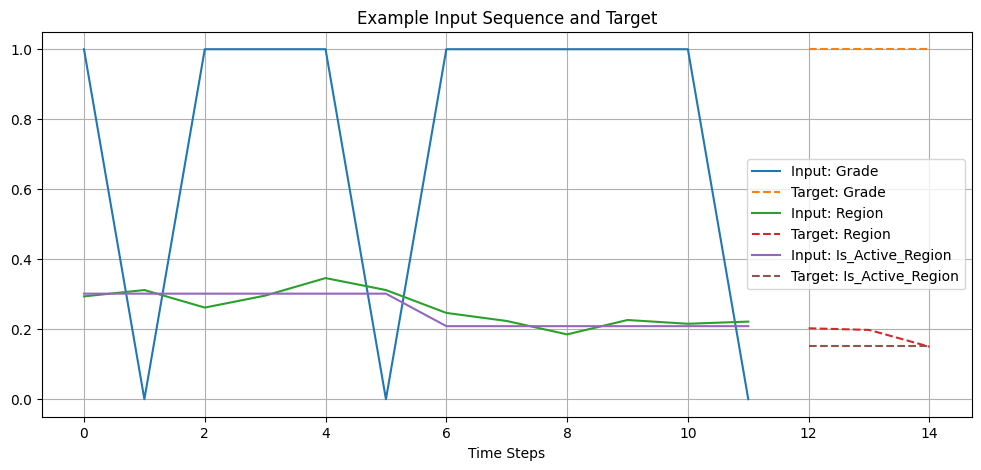

In [29]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(features[:3]):  # plot only first 3 features for clarity
    plt.plot(X_train[0][:, i], label=f'Input: {feature}')
    plt.plot(range(len(X_train[0]), len(X_train[0]) + len(y_train[0])), y_train[0][:, i], '--', label=f'Target: {feature}')
plt.title("Example Input Sequence and Target")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()
plt.show()